In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf') # note that we need to have tensorflow dimension ordering still because of the weigths.
print('The backend is:',K.backend())
import tensorflow as tf
print(K.image_dim_ordering()) # should say tf
print(tf.__version__) 

Using TensorFlow backend.


The backend is: tensorflow
tf
1.4.0


In [3]:
# Import relevant packages
import h5py
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#from matplotlib import ticker
#import seaborn as sns
%matplotlib inline 

from PIL import Image

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
seed = 150
np.random.seed(seed)

In [4]:
# Load in and process data
!ls

Untitled.ipynb
archive
catvsdogs_VGG16_pretrained_tf_top.h5
cnn_tensorflow_short_v1.ipynb
cnns-catsvsdogs-50imgs_afo_v5.ipynb
data
features_test.npy
features_train.npy
features_validation.npy
intro_to_keras_v1.ipynb
mod_appendix.json
original data
preview
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
w_appendix.h5


In [5]:
# Look at files, note all cat images and dog images are unique
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:4]:
        print(f)

FOLDER ./data
.DS_Store
FOLDER ./data/test
10214769505696272.jpg
10214769648783681.jpg
10214771823355944.jpg
10214776387874198.jpg
FOLDER ./data/train
FOLDER ./data/train/E
114634502635280.jpg
115446745886429.jpg
119371252160555.jpg
121041068588910.jpg
FOLDER ./data/train/I
103955050372901.jpg
106101140156824.jpg
107729153327634.jpg
111430939623126.jpg
FOLDER ./data/validation
FOLDER ./data/validation/E
114634502635280.jpg
122737501776766.jpg
132584087463634.jpg
132867420802701.jpg
FOLDER ./data/validation/I
1001091583356351.jpg
1004190739722068.jpg
1010717142403190.jpg
1011847008955121.jpg


In [7]:
print('Number of cat training images:', len(next(os.walk('./data/train/E'))[2]))
print('Number of dog training images:', len(next(os.walk('./data/train/I'))[2]))
print('Number of cat validation images:', len(next(os.walk('./data/validation/E'))[2]))
print('Number of dog validation images:', len(next(os.walk('./data/validation/I'))[2]))
print('Number of uncategorized test images:', len(next(os.walk('./data/test/EvI'))[2]))

# There should be 1000 train cat images, 1000 train dogs, 400 validation cats, 400 validation dogs, 100 uncategorized

Number of cat training images: 1000
Number of dog training images: 1000
Number of cat validation images: 400
Number of dog validation images: 400
Number of uncategorized test images: 100


In [8]:
# Define variables
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #one mixed category

img_width, img_height = 150, 150

n_train_samples = 2000
n_validation_samples = 800
n_epoch = 30
n_test_samples = 100

In [14]:
# Function for saving bottleneck features
# This can take ~20mins to run

#  Run model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    from keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
    
    print('TensorFlow VGG16 model architecture loaded')
    
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small
    # input_shape with channels last
    
    
    # Rescale value we multiply the data before any other processing. 
    # Our original images consist in RGB coefficients in the 0-255, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
       
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=True) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        
        features = model.predict_generator(generator, steps=len(generator))
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    
    print('\nDone! Bottleneck features have been saved')


print('This has been done before the lecture! Takes 20+ mins to run.')
save_bottleneck_features()

This has been done before the lecture! Takes 20+ mins to run.
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 100 images belonging to 1 classes.
Generate train image features
Found 2000 images belonging to 2 classes.
Generate validation image features
Found 800 images belonging to 2 classes.

Done! Bottleneck features have been saved


In [15]:
# Extra
# Obtain class labels and binary classification for validation data
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 800 images belonging to 2 classes.

Classifications:
 {'E': 0, 'I': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 

In [35]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

def train_model():
    train_data = np.load('features_train.npy')
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

    validation_data = np.load('features_validation.npy')
    # same as val_labels above
    validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

    # Add top layers trained ontop of extracted VGG features
    # Small fully connected model trained on top of the stored features
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    '''
    #We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    #To go with it we will also use the binary_crossentropy loss to train our model.

    '''
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=n_epoch, batch_size=32,
              validation_data=(validation_data, validation_labels),
              shuffle=True) # fit the model

    # Save weights to disk

    # Save model architecture to disk
    model_json = model.to_json()
    with open("mod_appendix.json", "w") as json_file: # save model
        json_file.write(model_json)
    
    # Save model weights
    model.save_weights("EvI_VGG16_pretrained_tf_top.h5") # save weights
    print("Saved model to disk")
    print('Done!')
    
    return(model)
    
model = train_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 1s 735us/step - loss: 1.6138 - acc: 0.4985 - val_loss: 0.6969 - val_acc: 0.4913
Epoch 2/30
2000/2000 [==============================] - 1s 582us/step - loss: 0.7259 - acc: 0.5145 - val_loss: 0.7017 - val_acc: 0.5000
Epoch 3/30
2000/2000 [==============================] - 1s 597us/step - loss: 0.7132 - acc: 0.5345 - val_loss: 0.7537 - val_acc: 0.5038
Epoch 4/30
2000/2000 [==============================] - 1s 594us/step - loss: 0.7078 - acc: 0.5500 - val_loss: 0.7929 - val_acc: 0.4988
Epoch 5/30
2000/2000 [==============================] - 1s 577us/step - loss: 0.6799 - acc: 0.5675 - val_loss: 0.7234 - val_acc: 0.4900
Epoch 6/30
2000/2000 [==============================] - 1s 592us/step - loss: 0.6718 - acc: 0.5955 - val_loss: 0.7994 - val_acc: 0.5025
Epoch 7/30
2000/2000 [==============================] - 1s 589us/step - loss: 0.6634 - acc: 0.6175 - val_loss: 0.7167 - val_acc: 0.5050
E

In [36]:
validation_data = np.load('features_validation.npy')

val_pred_class = model.predict_classes(validation_data,verbose=0) # predict image classes 
val_pred_prob = model.predict_proba(validation_data,verbose=0) # predict image probabilities

print('Accuracy on validation set: ',np.mean(val_pred_class.ravel()==val_labels)*100,'%')

print('\nVal loss & val_acc')
print(model.evaluate(validation_data,val_labels,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

Accuracy on validation set:  52.25 %

Val loss & val_acc
[1.6271565914154054, 0.52249999999999996]


In [37]:
# Alternative
print('Model accuracy on validation set:',model.evaluate(validation_data,val_labels,verbose=0)[1]*100,'%')

Model accuracy on validation set: 52.25 %


In [33]:
## Print try images:

# Use the model trained in Problem 1 to classify the test data images.
# Create a function that loads one image from the test data and then predicts
# if it is a cat or a dog and with what probability it thinks it is a cat or a dog
#
# Use variable test_data to make predictions
# Use list test_images to obtain the file name for all images (Note: test_images[0] corresponds to test_data[0])
# Use function plot_pic(img) to plot the image file

## Load in processed images feature to feed into bottleneck model

test_data = np.load('features_test.npy')

test_images =  [TEST_DIR+'EvI/'+img for img in os.listdir(TEST_DIR+'EvI/')]

def read_image(file_path):
    # For image visualization
    #im = np.array(Image.open(file_path))
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return img

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



I think this is a E with 97.88709% probability


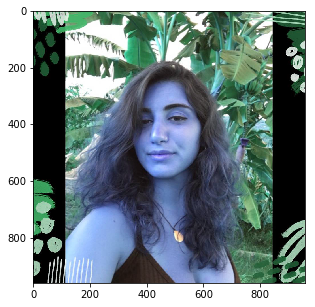



I think this is a I with 57.28419% probability


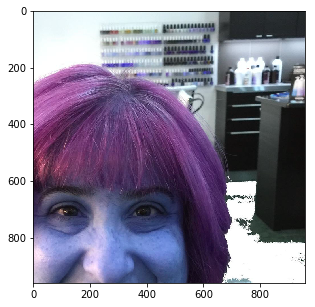



I think this is a I with 99.86882% probability


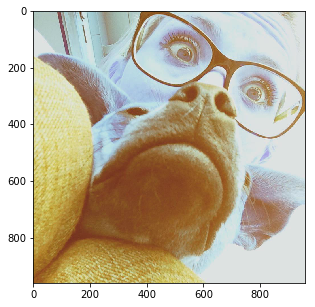



I think this is a I with 98.65941% probability


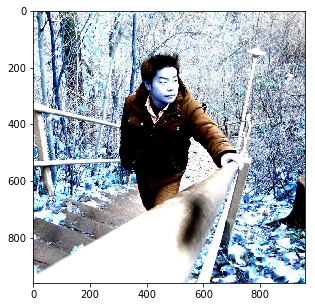



I think this is a E with 78.88848% probability


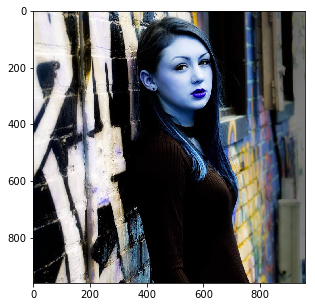



I think this is a E with 94.61448% probability


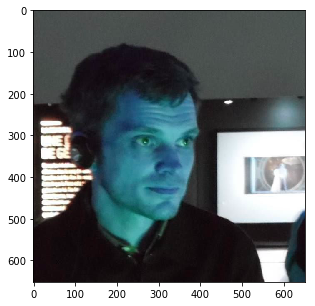



I think this is a E with 74.00652% probability


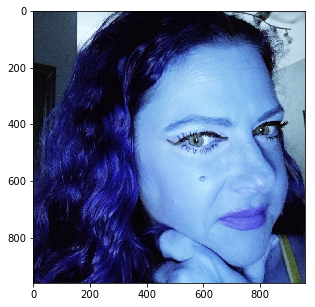



I think this is a I with 80.59459% probability


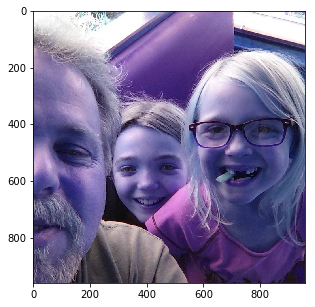



I think this is a E with 68.94606% probability


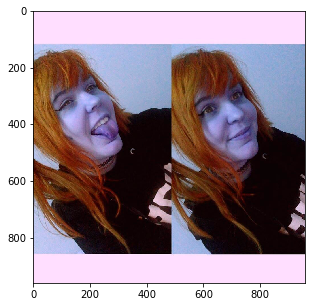



I think this is a E with 99.15612% probability


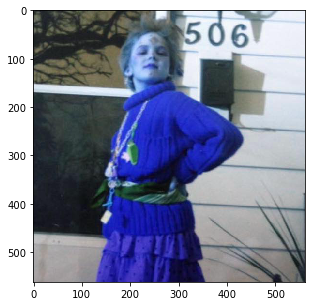



I think this is a I with 51.38069% probability


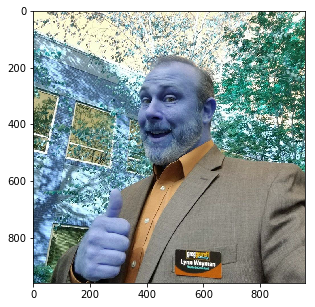



I think this is a E with 99.91221% probability


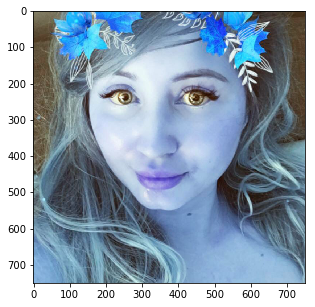



I think this is a E with 97.85125% probability


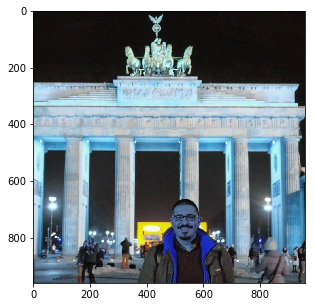



I think this is a I with 96.65769% probability


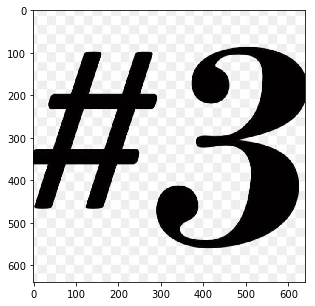



I think this is a E with 99.86821% probability


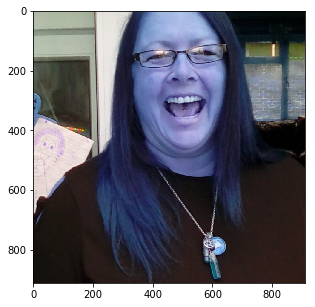



I think this is a E with 97.67715% probability


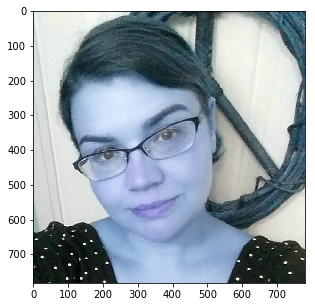



I think this is a E with 99.63707% probability


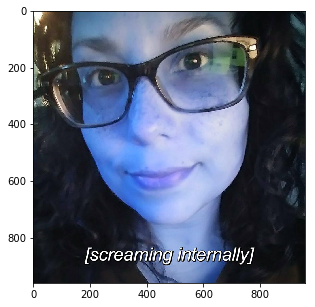



I think this is a E with 91.09843% probability


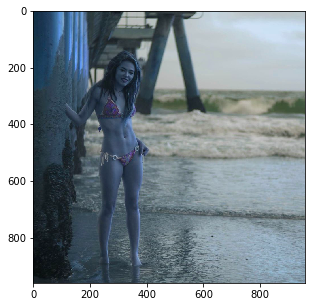



I think this is a E with 99.68682% probability


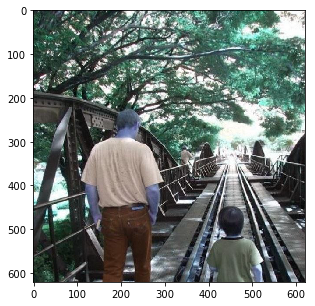



I think this is a I with 66.76768% probability


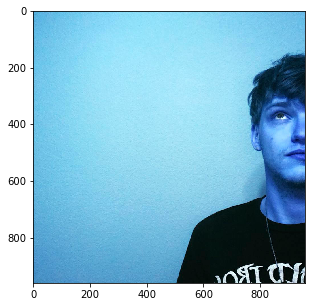



I think this is a E with 98.66859% probability


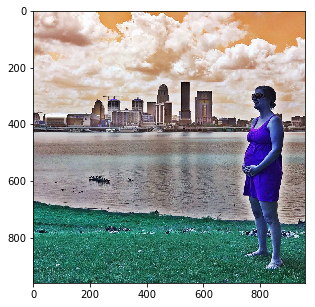



I think this is a E with 67.81814% probability


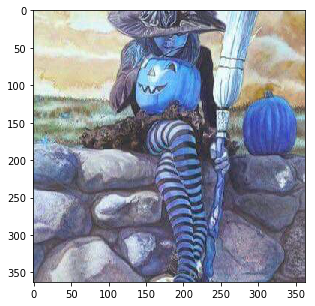



I think this is a E with 57.66506% probability


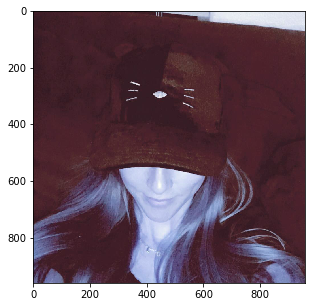



I think this is a E with 99.38825% probability


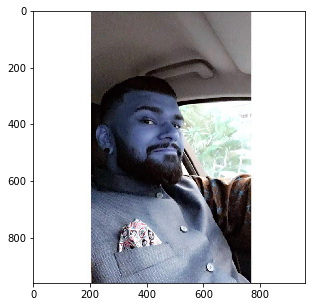



I think this is a E with 80.42424% probability


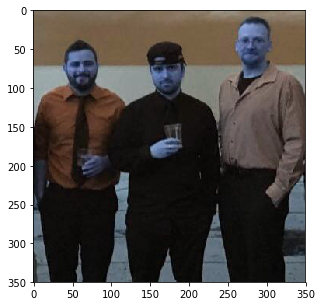



I think this is a E with 77.59109% probability


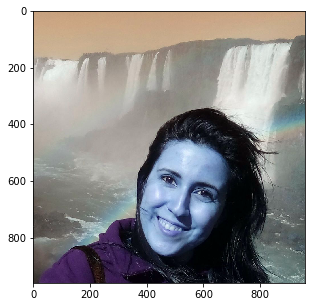



I think this is a E with 91.23116% probability


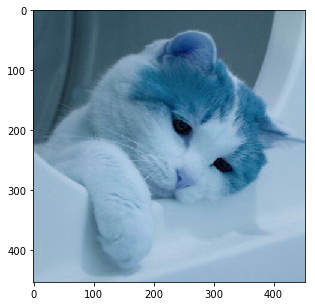



I think this is a E with 97.65738% probability


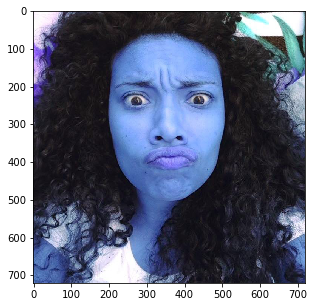



I think this is a E with 97.42863% probability


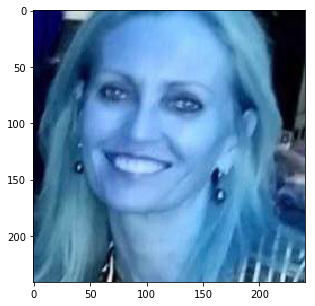



I think this is a E with 96.90709% probability


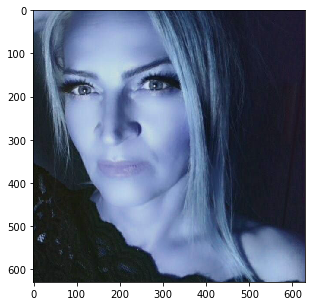



I think this is a E with 99.97538% probability


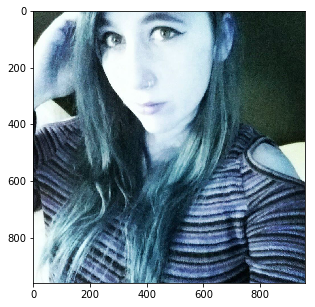



I think this is a I with 51.70165% probability


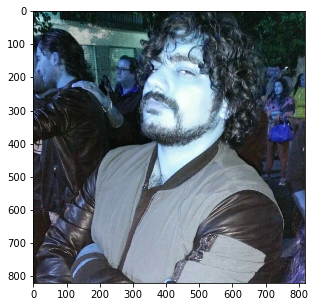



I think this is a I with 62.81723% probability


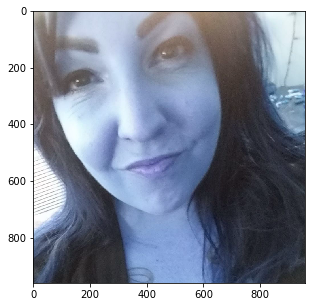



I think this is a E with 96.00459% probability


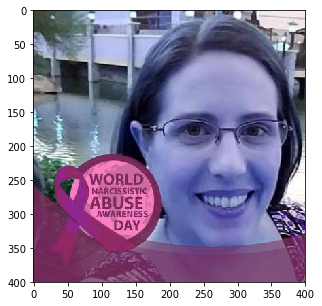



I think this is a E with 88.4097% probability


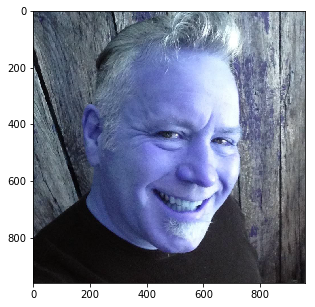



I think this is a E with 76.07349% probability


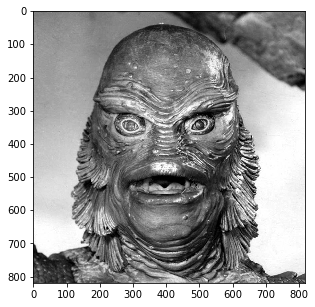

In [34]:
## Answer
import warnings
warnings.filterwarnings('ignore') # filter eventual warning

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='E'
        else:
            class_guess='I'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        if test_images[idx]=='./data/test/EvI/.DS_Store':
            continue
        plot_pic(test_images[idx])

predict(model,r=range(0,len(test_data)-64)) # seems to be doing really well